# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification problem (`Low`, `Medium`, `High`). It covers all stages from hyperparameter tuning to final model evaluation and baseline comparison.

## Table of Contents
**Step 1: Environment & Setup**  
**Step 2: Model Definition**  
**Step 3: Evaluation Function**  
**Step 4: Hyperparameter Sweep (10-Fold CV)**  
**Step 5: Retraining & Validation (10-Fold CV)**  
**Step 6: Cross-Validation Results Visualization**  
**Step 7: Ensemble Averaging**  
**Step 8: Final Model Training & Test Evaluation**  
**Step 9: Baseline QSAR Comparison**  

---

## Prerequisites
- Python 3.8+  
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (for earlier feature extraction scripts)  
- A GPU is recommended but not required.

Install requirements with:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths:  
  - `base_path`: directory with 10-fold train/val/test splits.  
  - `results_dir`: output folder for model checkpoints and metrics.  
- Detect GPU/CPU device.

## Step 2: Model Definition
Defines two classes:
- `MPNNLayer`: a message-passing layer with linear transforms, edge projections, and optional dropout.
- `MPNN`: stacks two `MPNNLayer`s, applies global mean pooling, and a final classification head.

## Step 3: Evaluation Function
`evaluate(model, loader)` runs the model in `eval()` mode over a DataLoader and returns concatenated logits and true labels.

## Step 4: Hyperparameter Sweep (10-Fold CV)
- Grid search over `hidden_dim`, `dropout`, and `learning rate`.  
- For each configuration, perform 10-fold CV:  
  - Train each fold for 50 epochs.  
  - Evaluate AUC-ROC on validation.  
- Record mean ± std AUC across folds.  
- Display a DataFrame of sweep results to select best hyperparameters.

## Step 5: Retraining & Validation (10-Fold CV)
Using the selected `best_hidden_dim`, `best_dropout`, and `best_lr`:
- Retrain each of the 10 folds with early stopping (patience = 10).  
- Save the best model weights for each fold.  
- Compute per-fold metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv` with a `fold` column.

## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± standard deviation of metrics.

## Step 7: Ensemble Averaging
- Load the 10 fold-model checkpoints.  
- Run each on the hold-out test set and collect logits.  
- Compute the average of logits across folds.  
- Derive final class predictions.  
- Save `ensemble_preds.csv` (True vs Pred).

## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds.  
- Reserve 10% for validation (stratified).  
- Train final model with early stopping and LR scheduler.  
- Evaluate on original test set:  
  - Compute accuracy, precision, recall, F1, AUC-ROC.  
  - Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv` and plots (`final_confusion_matrix.png`, `final_auc_roc.png`).

## Step 9: Baseline QSAR Comparison
- Load `QSAR_classification_performance_summary.csv`.  
- Automatically select the best baseline (highest accuracy) and report its `model_type` and `input_type`.  
- Compare baseline vs. final MPNN on accuracy, precision, recall, F1, AUC.  
- Display a comparison table.  
- Plot side-by-side bar chart and radar plot.

---

## Parameters & Extensions
- **Epochs**: default 50 for CV, 100 for retraining.  
- **Patience**: 10 for early stopping (can adjust).  
- **LR Scheduler**: `ReduceLROnPlateau` on validation loss.  

---




## 1. Imports and Setup

In [50]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [ ]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

task = "classification"  # or "regression"
#task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"MPNN_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define MPNN Layer and MPNN Model with Dropout Support
# Enhanced MPNN model with dropout layers after each message-passing block to reduce overfitting.

In [59]:
class MPNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim):
        super().__init__(aggr='add')
        self.lin = Linear(in_channels, out_channels)
        self.edge_proj = Linear(edge_dim, out_channels)
        self.msg_lin = Linear(out_channels, out_channels)

    def forward(self, x, edge_index, edge_attr):
        x = self.lin(x)
        edge_attr = self.edge_proj(edge_attr)
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        return self.msg_lin(x_j + edge_attr)

    def update(self, aggr_out):
        return F.relu(aggr_out)

class MPNN(torch.nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, output_dim, dropout=0.0):
        super().__init__()
        self.dropout = dropout
        self.mp1 = MPNNLayer(input_dim, hidden_dim, edge_dim)
        self.mp2 = MPNNLayer(hidden_dim, hidden_dim, edge_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.mp1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.mp2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, data.batch)
        return self.out(x)


## 4. Evaluation Helper Function

In [60]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [61]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [ ]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd

hidden_dims = [64, 128, 256]
dropouts    = [0.0, 0.2, 0.4]
lrs         = [1e-3, 5e-4, 1e-4]

results = []

for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"\n🔧 Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            auc_scores = []
            bal_scores = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))
                
                model = MPNN(train_data[0].x.size(1),
                             train_data[0].edge_attr.size(1),
                             hidden_dim=hd,
                             output_dim=num_classes,
                             dropout=dp).to(device)
                opt = torch.optim.Adam(model.parameters(), lr=lr)
                tr = DataLoader(train_data, batch_size=32, shuffle=True,
                                worker_init_fn=seed_worker, generator=generator)
                vl = DataLoader(val_data,   batch_size=32)

                # Train
                for epoch in range(1, 51):
                    model.train()
                    for batch in tr:
                        batch = batch.to(device)
                        opt.zero_grad()
                        out = model(batch)
                        loss = F.cross_entropy(out, batch.y.long())
                        loss.backward()
                        opt.step()

                # Eval
                preds, labels = evaluate(model, vl)
                y_true = labels.numpy().astype(int)
                y_probs = F.softmax(preds, dim=1).numpy()
                y_pred  = preds.argmax(dim=1).numpy()

                # AUC‑ROC (one-vs-rest)
                auc = roc_auc_score(
                    label_binarize(y_true, classes=np.arange(num_classes)),
                    y_probs, multi_class='ovr'
                )
                auc_scores.append(auc)

                # Balanced Accuracy
                bal = balanced_accuracy_score(y_true, y_pred)
                bal_scores.append(bal)

            # Record mean±std for both metrics
            results.append({
                "hidden_dim": hd,
                "dropout":    dp,
                "lr":         lr,
                "mean_auc":   np.mean(auc_scores),
                "std_auc":    np.std(auc_scores),
                "mean_balanced_acc": np.mean(bal_scores),
                "std_balanced_acc":  np.std(bal_scores),
            })

            print(f"📊 AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f} | "
                  f"Balanced Acc: {np.mean(bal_scores):.4f} ± {np.std(bal_scores):.4f}")

# Build DataFrame and sort by mean balanced accuracy (or mean_auc)
sweep_df = pd.DataFrame(results)
display(sweep_df.sort_values("mean_balanced_acc", ascending=False))
# Save the results
sweep_df.to_csv(os.path.join(results_dir, "sweep_results.csv"), index=False)


In [ ]:

# Load the best model configuration
best_config = sweep_df.loc[sweep_df["mean_balanced_acc"].idxmax()]
best_hidden_dim = best_config["hidden_dim"]
best_dropout = best_config["dropout"]
best_lr = best_config["lr"]
print(f"Best config: hidden_dim={best_hidden_dim}, dropout={best_dropout}, lr={best_lr}")

# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [65]:
# %%
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pandas as pd
fold_metrics = []


for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = MPNN(train_data[0].x.size(1),
                 train_data[0].edge_attr.size(1),
                 hidden_dim=best_hidden_dim,
                 output_dim=num_classes,
                 dropout=best_dropout).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=best_lr)
    tr = DataLoader(train_data, batch_size=32, shuffle=True,
                    worker_init_fn=seed_worker, generator=generator)
    vl = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf'); patience=0
    for epoch in range(1, 101):
        model.train(); total=0
        for batch in tr:
            batch=batch.to(device); opt.zero_grad(); out=model(batch)
            loss=F.cross_entropy(out,batch.y.long()); loss.backward(); opt.step(); total+=loss.item()
        preds, labels = evaluate(model, vl)
        y_true = labels.numpy().astype(int)
        y_probs = F.softmax(preds, dim=1).numpy()
        val_loss = F.cross_entropy(preds, labels.long()).item()
        print(f"Epoch {epoch:03d} | Train Loss: {total_loss / len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss<best_val_loss:
            best_val_loss=val_loss; patience=0
            torch.save(model.state_dict(), os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience+=1
            if patience>=10: break
    print(f"Best val loss: {best_val_loss:.4f} | Early stopping patience: {patience}")
    

    # Metrics
    y_pred = preds.argmax(dim=1).numpy()
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    auc = roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), y_probs, multi_class='ovr')
    fold_metrics.append({"fold":fold+1,"accuracy":acc,"precision":precision,"recall":recall,"f1_score":f1,"auc_roc":auc})

# Save CV summary
cv_df = pd.DataFrame(fold_metrics)
cv_df.to_csv(os.path.join(results_dir, "crossval_summary.csv"), index=False)
print("✅ Saved CV summary")



🔁 Retraining Fold 1/10
Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8811
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8632
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8495
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8588
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8363
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8373
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8444
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8556
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8261
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.7992
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.8179
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.7861
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.7690
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.7556
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.7415
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.7671
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7262
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.7186
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7133
Epoch 020 | Train Loss: 0.

/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8768
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8611
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8586
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8466
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8341
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8386
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8159
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.7984
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.7877
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.7948
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.7842
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.7910
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.7869
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.7483
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.7643
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.8535
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7527
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.7402
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7467
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7835


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8660
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8624
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8508
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8598
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8685
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8428
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8312
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8515
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8227
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.7967
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.7767
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.7797
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.8179
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8520
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.8096
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.7533
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.8137
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.8154
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7598
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7392


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8657
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8614
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8528
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8495
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8402
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8306
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8156
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8186
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8004
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.7814
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.7719
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.7706
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.7392
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.7249
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.7483
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.7215
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7066
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.6928
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7081
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7499


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8962
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8924
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8914
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8943
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8676
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8922
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8741
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8723
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8708
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.8450
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.8522
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.8353
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.8378
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8445
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.8454
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.8249
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.8642
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.8462
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.8279
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.8061


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.9310
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8883
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8895
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8802
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8762
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8650
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8692
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8598
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8606
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.8414
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.8332
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.9144
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.8447
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8351
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.8329
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.8263
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.8293
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.8150
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.8363
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.8707


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8583
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8503
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8406
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8439
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8482
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8203
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8123
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.7907
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8187
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.7687
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.7354
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.7272
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.7351
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.7290
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.7121
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.7543
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7292
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.7150
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7365
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7117


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8964
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8724
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8657
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.9005
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8681
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8591
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8536
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8600
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8696
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.8492
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.8494
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.8295
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.8702
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8443
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.8316
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.8132
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.8148
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.8097
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.8149
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.8097


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8830
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8812
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8669
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8602
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8547
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8632
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8444
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8338
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8261
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.8270
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.8529
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.8203
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.8538
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8435
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.8255
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.8334
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7826
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.8174
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7777
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7794


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 001 | Train Loss: 0.7402 | Val Loss: 0.8622
Epoch 002 | Train Loss: 0.7402 | Val Loss: 0.8643
Epoch 003 | Train Loss: 0.7402 | Val Loss: 0.8567
Epoch 004 | Train Loss: 0.7402 | Val Loss: 0.8414
Epoch 005 | Train Loss: 0.7402 | Val Loss: 0.8346
Epoch 006 | Train Loss: 0.7402 | Val Loss: 0.8209
Epoch 007 | Train Loss: 0.7402 | Val Loss: 0.8147
Epoch 008 | Train Loss: 0.7402 | Val Loss: 0.8316
Epoch 009 | Train Loss: 0.7402 | Val Loss: 0.8523
Epoch 010 | Train Loss: 0.7402 | Val Loss: 0.8493
Epoch 011 | Train Loss: 0.7402 | Val Loss: 0.7778
Epoch 012 | Train Loss: 0.7402 | Val Loss: 0.8255
Epoch 013 | Train Loss: 0.7402 | Val Loss: 0.7773
Epoch 014 | Train Loss: 0.7402 | Val Loss: 0.8110
Epoch 015 | Train Loss: 0.7402 | Val Loss: 0.7732
Epoch 016 | Train Loss: 0.7402 | Val Loss: 0.7631
Epoch 017 | Train Loss: 0.7402 | Val Loss: 0.7632
Epoch 018 | Train Loss: 0.7402 | Val Loss: 0.7639
Epoch 019 | Train Loss: 0.7402 | Val Loss: 0.7734
Epoch 020 | Train Loss: 0.7402 | Val Loss: 0.7663


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# ## Step 6: Visualize Cross-Validation Results


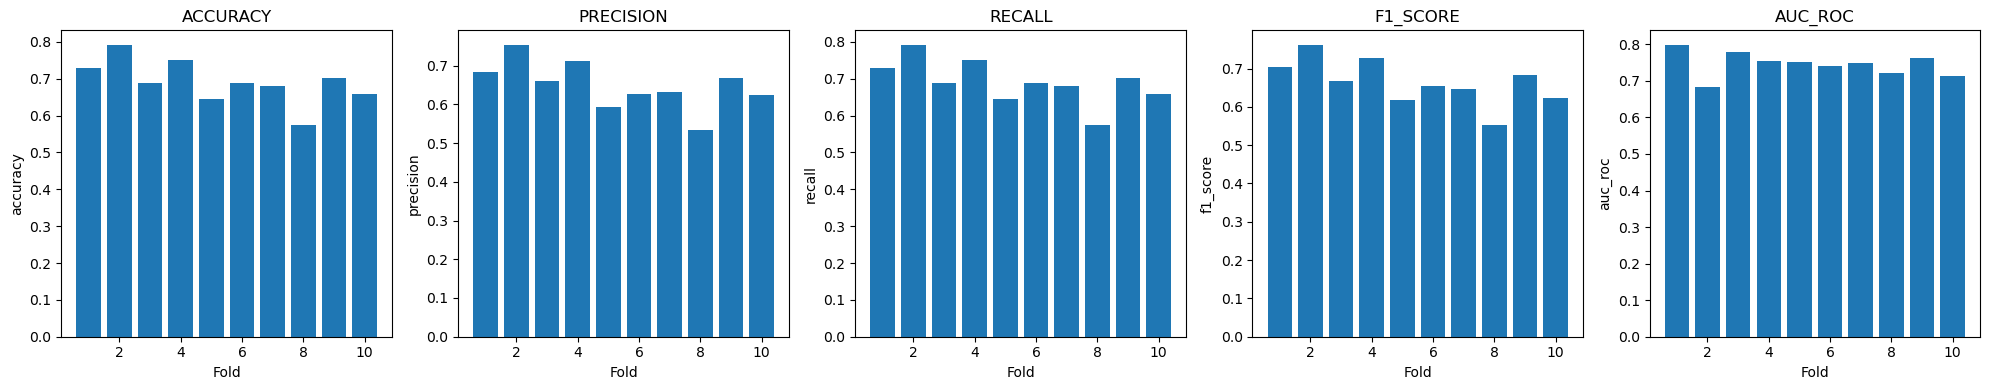

In [66]:

# %%
cv_df = pd.read_csv(os.path.join(results_dir, "crossval_summary.csv"))
metrics = ['accuracy','precision','recall','f1_score','auc_roc']
fig, axs = plt.subplots(1,len(metrics), figsize=(20,4))
for i,m in enumerate(metrics):
    axs[i].bar(cv_df['fold'], cv_df[m]); axs[i].set_title(m.upper()); axs[i].set_xlabel('Fold'); axs[i].set_ylabel(m)
plt.tight_layout(); plt.show()

# ## Step 7: Ensemble Averaging from 10 CV Models


In [67]:

# %%
ess_preds=[]
test_data=torch.load(os.path.join(base_path, f"{task}_test.pt"))
tl=DataLoader(test_data, batch_size=32)
for fold in range(10):
    model = MPNN(test_data[0].x.size(1), test_data[0].edge_attr.size(1), hidden_dim=best_hidden_dim, output_dim=num_classes, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval(); outs=[]
    with torch.no_grad():
        for b in tl: outs.append(model(b.to(device)).cpu())
    ess_preds.append(torch.cat(outs,0))
avg=torch.stack(ess_preds).mean(0)
f_pred=avg.argmax(1).numpy(); t_true=torch.cat([d.y for d in test_data]).numpy().astype(int)
pd.DataFrame({'True':t_true,'Pred':f_pred}).to_csv(os.path.join(results_dir,'ensemble_preds.csv'),index=False)
print('✅ Ensemble preds saved')

✅ Ensemble preds saved


# ## Step 7b: Ensemble Model Evaluation – Confusion Matrix & AUC‑ROC


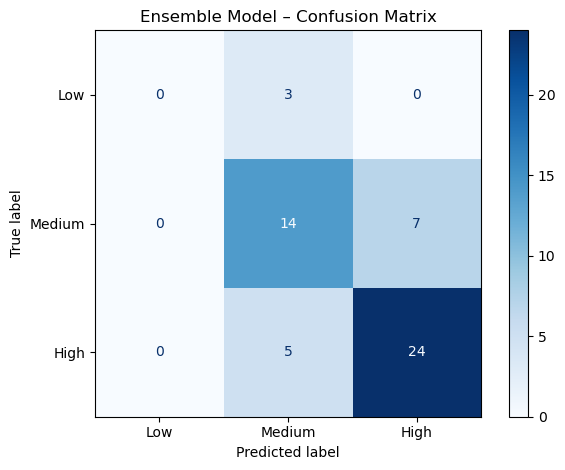

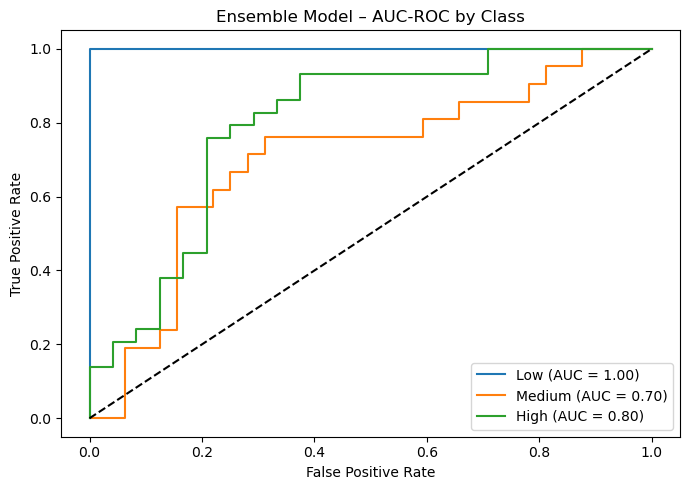

In [68]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Load ensemble predictions
ens_df = pd.read_csv(os.path.join(results_dir, 'ensemble_preds.csv'))
y_true_ens = ens_df['True'].values
y_pred_ens = ens_df['Pred'].values

# 1) Confusion matrix
cm = confusion_matrix(y_true_ens, y_pred_ens)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[class_names[i] for i in range(num_classes)])
disp.plot(cmap='Blues')
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

# 2) AUC‑ROC per class
# Need probability estimates – reload avg_output if available or recompute probabilities
# If you only have hard preds, rerun ensemble loop with model outputs saved as probs:
#     avg_probs = torch.stack(ensemble_prob_lists).mean(0).numpy()
# For now, assuming you have `avg_probs`:
y_probs = avg_output.softmax(dim=1).numpy()  # or your stored avg_probs
y_true_bin = label_binarize(y_true_ens, classes=np.arange(num_classes))

plt.figure(figsize=(7,5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Ensemble Model – AUC‑ROC by Class")
plt.legend()
plt.tight_layout()
plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


/Users/dolapo/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 001 | Train Loss: 0.8502 | Val Loss: 0.8369 | Best Val Loss: 0.8369 | Patience: 0
Epoch 002 | Train Loss: 0.7688 | Val Loss: 0.7551 | Best Val Loss: 0.7551 | Patience: 0
Epoch 003 | Train Loss: 0.7468 | Val Loss: 0.7196 | Best Val Loss: 0.7196 | Patience: 0
Epoch 004 | Train Loss: 0.7260 | Val Loss: 0.7107 | Best Val Loss: 0.7107 | Patience: 0
Epoch 005 | Train Loss: 0.7210 | Val Loss: 0.6930 | Best Val Loss: 0.6930 | Patience: 0
Epoch 006 | Train Loss: 0.7188 | Val Loss: 0.6858 | Best Val Loss: 0.6858 | Patience: 0
Epoch 007 | Train Loss: 0.7160 | Val Loss: 0.6960 | Best Val Loss: 0.6858 | Patience: 1
Epoch 008 | Train Loss: 0.7170 | Val Loss: 0.7095 | Best Val Loss: 0.6858 | Patience: 2
Epoch 009 | Train Loss: 0.7037 | Val Loss: 0.6738 | Best Val Loss: 0.6738 | Patience: 0
Epoch 010 | Train Loss: 0.6958 | Val Loss: 0.6710 | Best Val Loss: 0.6710 | Patience: 0
Epoch 011 | Train Loss: 0.6890 | Val Loss: 0.6603 | Best Val Loss: 0.6603 | Patience: 0
Epoch 012 | Train Loss: 0.6842 |

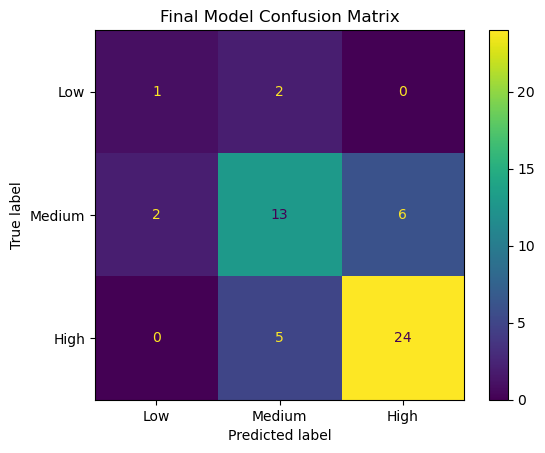

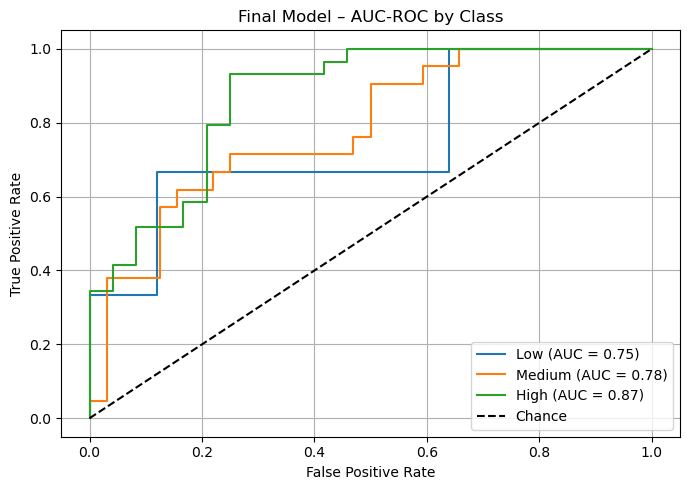

,Accuracy
ensemble,0.716981
final,0.716981


✅ Final metrics saved
✅ Final confusion matrix saved
✅ Final AUC-ROC saved
✅ Final predictions saved


In [71]:

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Merge train+val
all_data=[]
for fold in range(10):
    all_data+=torch.load(os.path.join(base_path,f"{task}_train_fold{fold}.pt"))
    all_data+=torch.load(os.path.join(base_path,f"{task}_val_fold{fold}.pt"))
# small val
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.1,random_state=seed)
labels=[int(d.y.item()) for d in all_data]
train_idx,val_idx=next(sss.split(all_data,labels))
train_split=[all_data[i] for i in train_idx]; val_split=[all_data[i] for i in val_idx]
tr=DataLoader(train_split,batch_size=32,shuffle=True,worker_init_fn=seed_worker,generator=generator)
vl=DataLoader(val_split,batch_size=32)
model=MPNN(all_data[0].x.size(1),all_data[0].edge_attr.size(1),hidden_dim=best_hidden_dim,output_dim=num_classes,dropout=best_dropout).to(device)
opt=torch.optim.Adam(model.parameters(),lr=best_lr)
sched=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',patience=5,factor=0.5,verbose=True)
best_v=1e9;pat=0
for epoch in range(1,301):
    model.train();tot=0
    for b in tr: b=b.to(device);opt.zero_grad();o=model(b);l=F.cross_entropy(o,b.y.long());l.backward();opt.step();tot+=l.item()
    preds,labels=evaluate(model,vl);vloss=F.cross_entropy(preds,labels.long()).item();sched.step(vloss)
    if vloss<best_v:best_v=vloss;pat=0;torch.save(model.state_dict(),os.path.join(results_dir,'final_model.pt'))
    else: pat+=1
    if pat>=10:break
    print(f"Epoch {epoch:03d} | Train Loss: {tot/len(tr):.4f} | Val Loss: {vloss:.4f} | Best Val Loss: {best_v:.4f} | Patience: {pat}")

# test eval
model.load_state_dict(torch.load(os.path.join(results_dir,'final_model.pt')))
td=DataLoader(torch.load(os.path.join(base_path,f"{task}_test.pt")),batch_size=32)
preds,labels=evaluate(model,td);y_pred=preds.argmax(1).numpy();y_true=labels.numpy().astype(int)
# metrics
acc_f=accuracy_score(y_true,y_pred);prec,rec,f1,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
# confusion
cm=confusion_matrix(y_true,y_pred);disp=ConfusionMatrixDisplay(cm,display_labels=list(class_names.values()));disp.plot()
plt.title('Final Model Confusion Matrix');plt.show()
# final auc
 # Assume y_true is shape (n,) and preds is torch.Tensor of shape (n, num_classes)
probs     = F.softmax(preds, dim=1).cpu().numpy()     # (n, C)
y_true    = labels.numpy().astype(int)                 # (n,)
y_true_bin= label_binarize(y_true, classes=np.arange(num_classes))  # (n, C)

plt.figure(figsize=(7, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Model – AUC‑ROC by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

# Save final metrics
final_metrics = {
    'accuracy': acc_f,
    'precision': prec,
    'recall': rec,
    'f1_score': f1,
    'auc_roc': roc_auc_score(label_binarize(y_true, classes=np.arange(num_classes)), probs, multi_class='ovr')
}
final_metrics_df = pd.DataFrame(final_metrics, index=[0])
final_metrics_df.to_csv(os.path.join(results_dir, 'final_metrics.csv'), index=False)
print("✅ Final metrics saved")
# Save final confusion matrix
cm_df = pd.DataFrame(cm, index=class_names.values(), columns=class_names.values())
cm_df.to_csv(os.path.join(results_dir, 'final_confusion_matrix.csv'))
print("✅ Final confusion matrix saved")
# Save final AUC-ROC
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_auc = auc(fpr, tpr)
roc_df.to_csv(os.path.join(results_dir, 'final_auc_roc.csv'), index=False)
print("✅ Final AUC-ROC saved")
# Save final predictions
preds_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
preds_df.to_csv(os.path.join(results_dir, 'final_predictions.csv'), index=False)
print("✅ Final predictions saved")


## Step 9: compare ensemble averaging to final model training results

In [72]:
# Comparison table
ensemble_df=pd.read_csv(os.path.join(results_dir,'ensemble_preds.csv'))
ensemble_acc=accuracy_score(ensemble_df['True'],ensemble_df['Pred'])
final_metrics = {'ensemble': ensemble_acc, 'final': acc_f}
comp = pd.DataFrame.from_dict(final_metrics, orient='index', columns=['Accuracy'])
display(comp)

,Accuracy
ensemble,0.716981
final,0.716981
